# House prices prediction

## Gaggle link
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

## Goal

Predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

## Metric
> https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation

Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.) 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [3]:
print("Training set shape: ", train_df.shape)
print("Test set shape: ", test_df.shape)

Training set shape:  (1460, 81)
Test set shape:  (1459, 80)


As we can see train and test set have almost equal size.

In [4]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

As we can see there are numerical and categorical features in our data. Some of them have a lot of missing values

In [6]:
try:
    train_df = train_df.drop(['Id'], axis=1)
except KeyError:
    pass
print("Number of categorical cols", (train_df.dtypes == 'object').sum())
print("Number of numerical cols", (train_df.dtypes != 'object').sum())

Number of categorical cols 43
Number of numerical cols 37


## Data Exploration

### Analyze SalePrice

In [7]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

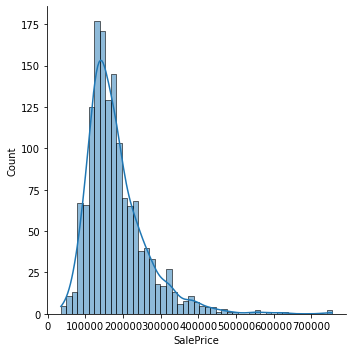

In [8]:
sns.displot(train_df, x='SalePrice', kde=True);

<AxesSubplot:xlabel='SalePrice'>

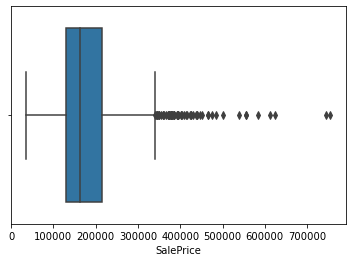

In [9]:
sns.boxplot(data=train_df, x='SalePrice')

In [10]:
# Skew and kurt
print("Skewness: %f" % train_df['SalePrice'].skew())
print("Kurtosis: %f" % train_df['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


Text(0.5, 1.0, 'lognorm')

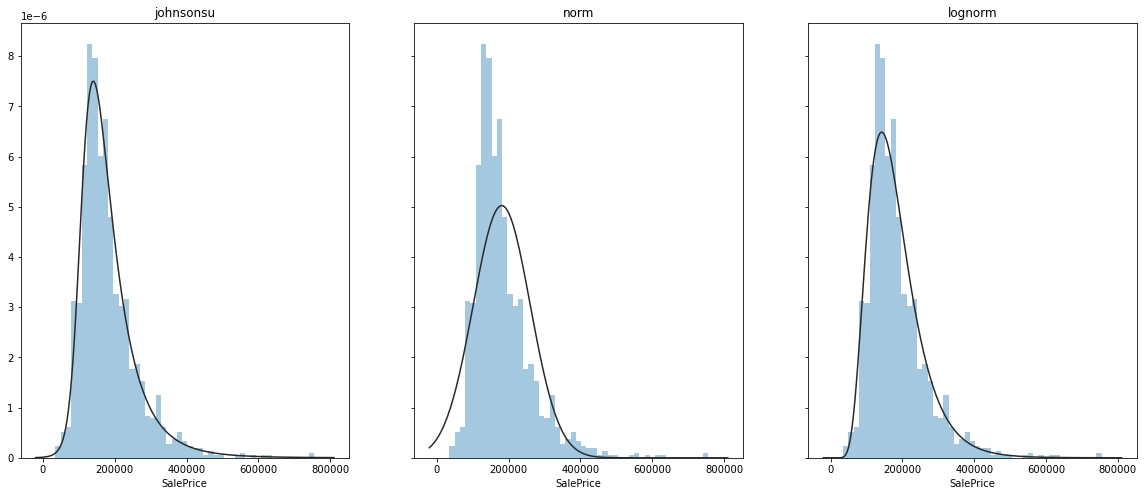

In [11]:
import scipy.stats as st

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True)
fig.set_size_inches(20, 8)
sns.distplot(train_df['SalePrice'], kde=False, fit=st.johnsonsu, ax=ax1)
ax1.set_title("johnsonsu")
sns.distplot(train_df['SalePrice'], kde=False, fit=st.norm, ax=ax2)
ax2.set_title("norm")
sns.distplot(train_df['SalePrice'], kde=False, fit=st.lognorm, ax=ax3)
ax3.set_title("lognorm")

It is clear that SalePrice doesn't follow normal distribution. Before regression, the data needs to be transformed. Both log transformation and Johnson distribution fit the data well.


### Missing Values

Text(0.5, 1.0, 'Missing value counts per column')

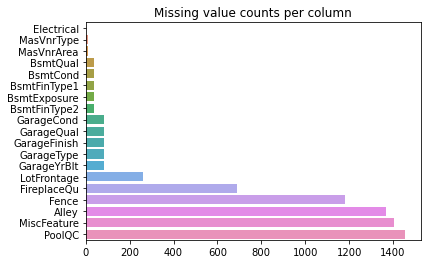

In [12]:
missing = train_df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
sns.barplot(x=missing, y=missing.index)
plt.title("Missing value counts per column")

### Separate numerical and categorical variables

In [13]:
numerical_features = [f for f in train_df.columns if train_df.dtypes[f] != 'object']
categorical_features = [f for f in train_df.columns if train_df.dtypes[f] == 'object']

print(f"Total Number of Numerical features : {len(numerical_features)}")
print(f"Number of categorical features : {len(categorical_features)}")

Total Number of Numerical features : 37
Number of categorical features : 43


### Numerical Features

In [14]:
numerical_features.sort()
print(numerical_features)

['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea', 'SalePrice', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']


We should be careful here as some columns might contain just numerical encoding for some unordered categories. For example:

**MSSubClass** : Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

In [15]:
numerical_features.remove('MSSubClass')

There are some columns related to basement area

**TotalBsmtSF**: Total square feet of basement area  
**BsmtFinSF1**: Type 1 finished square feet  
**BsmtFinSF2**: Type 2 finished square feet  
**BsmtUnfSF**: Unfinished square feet of basement area  

It seems that TotalBsmtSF is just a sum of the rest

In [16]:
total_bsmt_sf = train_df['BsmtFinSF1'] + train_df['BsmtFinSF2'] + train_df['BsmtUnfSF']
print(np.allclose(total_bsmt_sf, train_df['TotalBsmtSF']))

True


**GrLivArea**: Above grade (ground) living area square feet  
**1stFlrSF**: First Floor square feet  
**2ndFlrSF**: Second floor square feet  
**LowQualFinSF**: Low quality finished square feet (all floors)

In [17]:
gr_liv_area = train_df['1stFlrSF'] + train_df['2ndFlrSF'] + train_df['LowQualFinSF']
print(np.allclose(gr_liv_area, train_df['GrLivArea']))

True


In [18]:
# Number of unique values among columns with numeric data
train_df[numerical_features].nunique().sort_values()

HalfBath            3
BsmtHalfBath        3
KitchenAbvGr        4
FullBath            4
Fireplaces          4
BsmtFullBath        4
GarageCars          5
YrSold              5
PoolArea            8
BedroomAbvGr        8
OverallCond         9
OverallQual        10
TotRmsAbvGrd       12
MoSold             12
3SsnPorch          20
MiscVal            21
LowQualFinSF       24
YearRemodAdd       61
ScreenPorch        76
GarageYrBlt        97
LotFrontage       110
YearBuilt         112
EnclosedPorch     120
BsmtFinSF2        144
OpenPorchSF       202
WoodDeckSF        274
MasVnrArea        327
2ndFlrSF          417
GarageArea        441
BsmtFinSF1        637
SalePrice         663
TotalBsmtSF       721
1stFlrSF          753
BsmtUnfSF         780
GrLivArea         861
LotArea          1073
dtype: int64

In [19]:
discrete_features = [col for col in numerical_features if len(train_df[col].unique()) < 25]
continuous_features = [feature for feature in numerical_features if feature not in discrete_features]
print(f"Number of discrete features : {len(discrete_features)}")
print(f"No of continuous features are : {len(continuous_features)}")

Number of discrete features : 17
No of continuous features are : 19


#### Distribution of discrete features

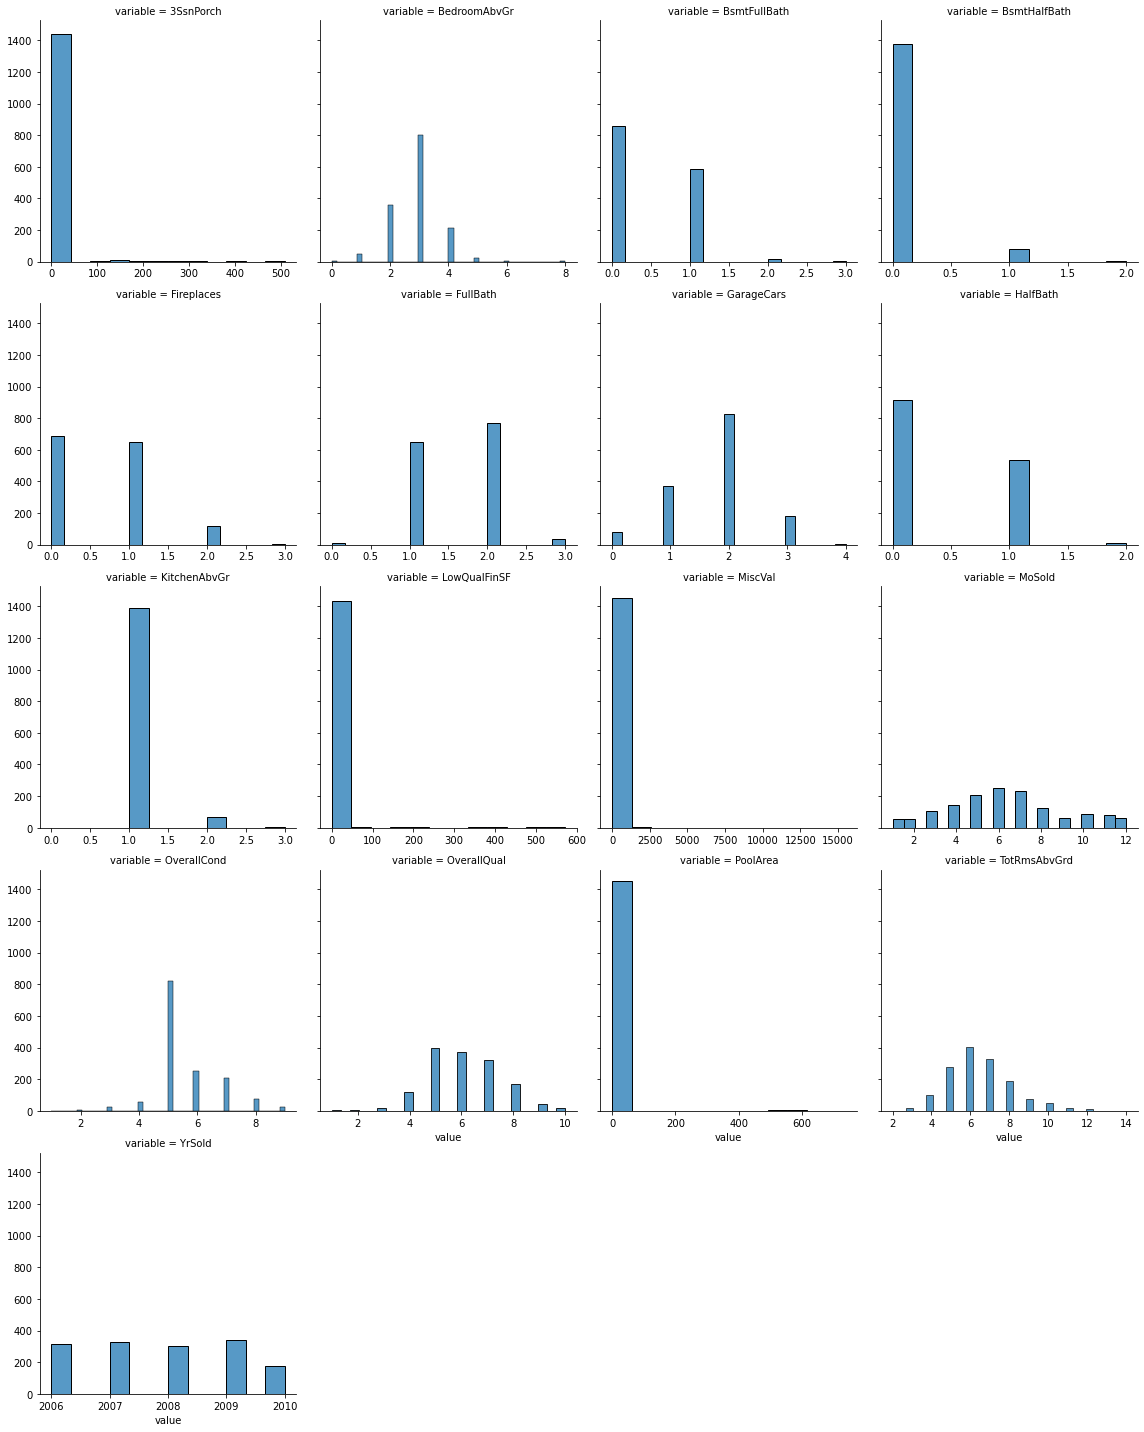

In [20]:
f = pd.melt(train_df, value_vars=discrete_features)
g = sns.FacetGrid(f, col="variable", col_wrap=4, sharex=False, sharey=True, size=4)
g = g.map(sns.histplot, "value")

* Some features are dominated by nan values (e.g., BsmtHalfBath, PoolArea, LowQualFinSF, 3SsnPorch, MiscVal ), thus we can consider to drop.

#### Distribution of continuous features

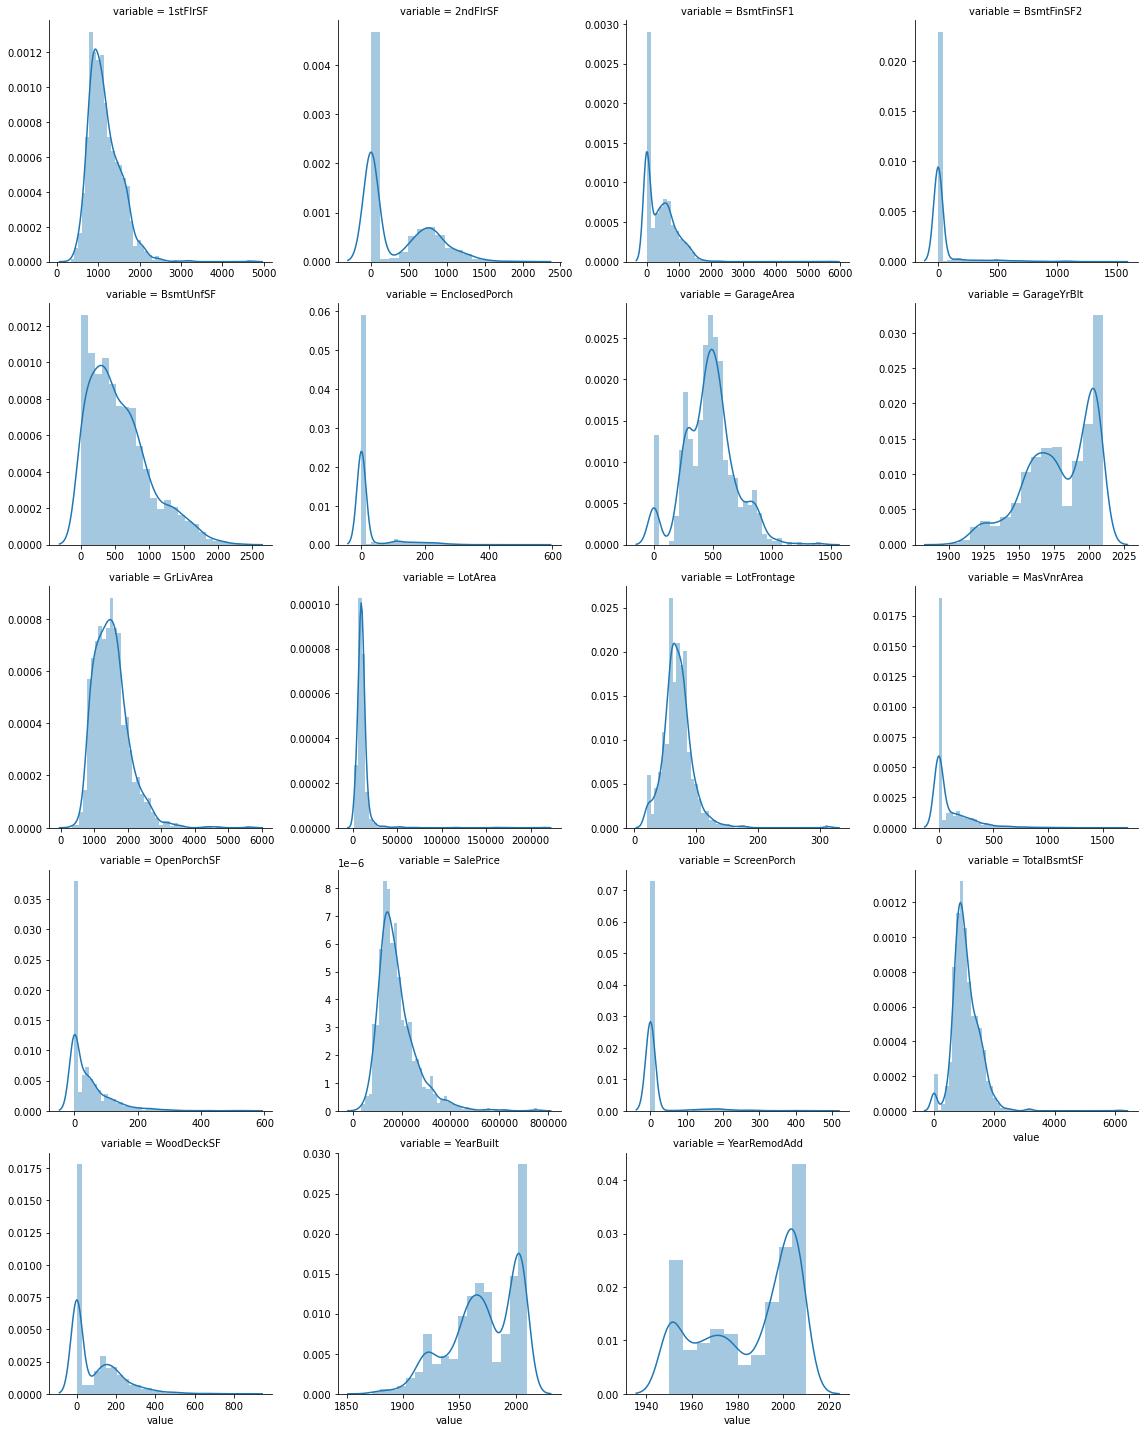

In [21]:
f = pd.melt(train_df, value_vars=continuous_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False, size=4)
g = g.map(sns.distplot, "value")

#### What features are linears?

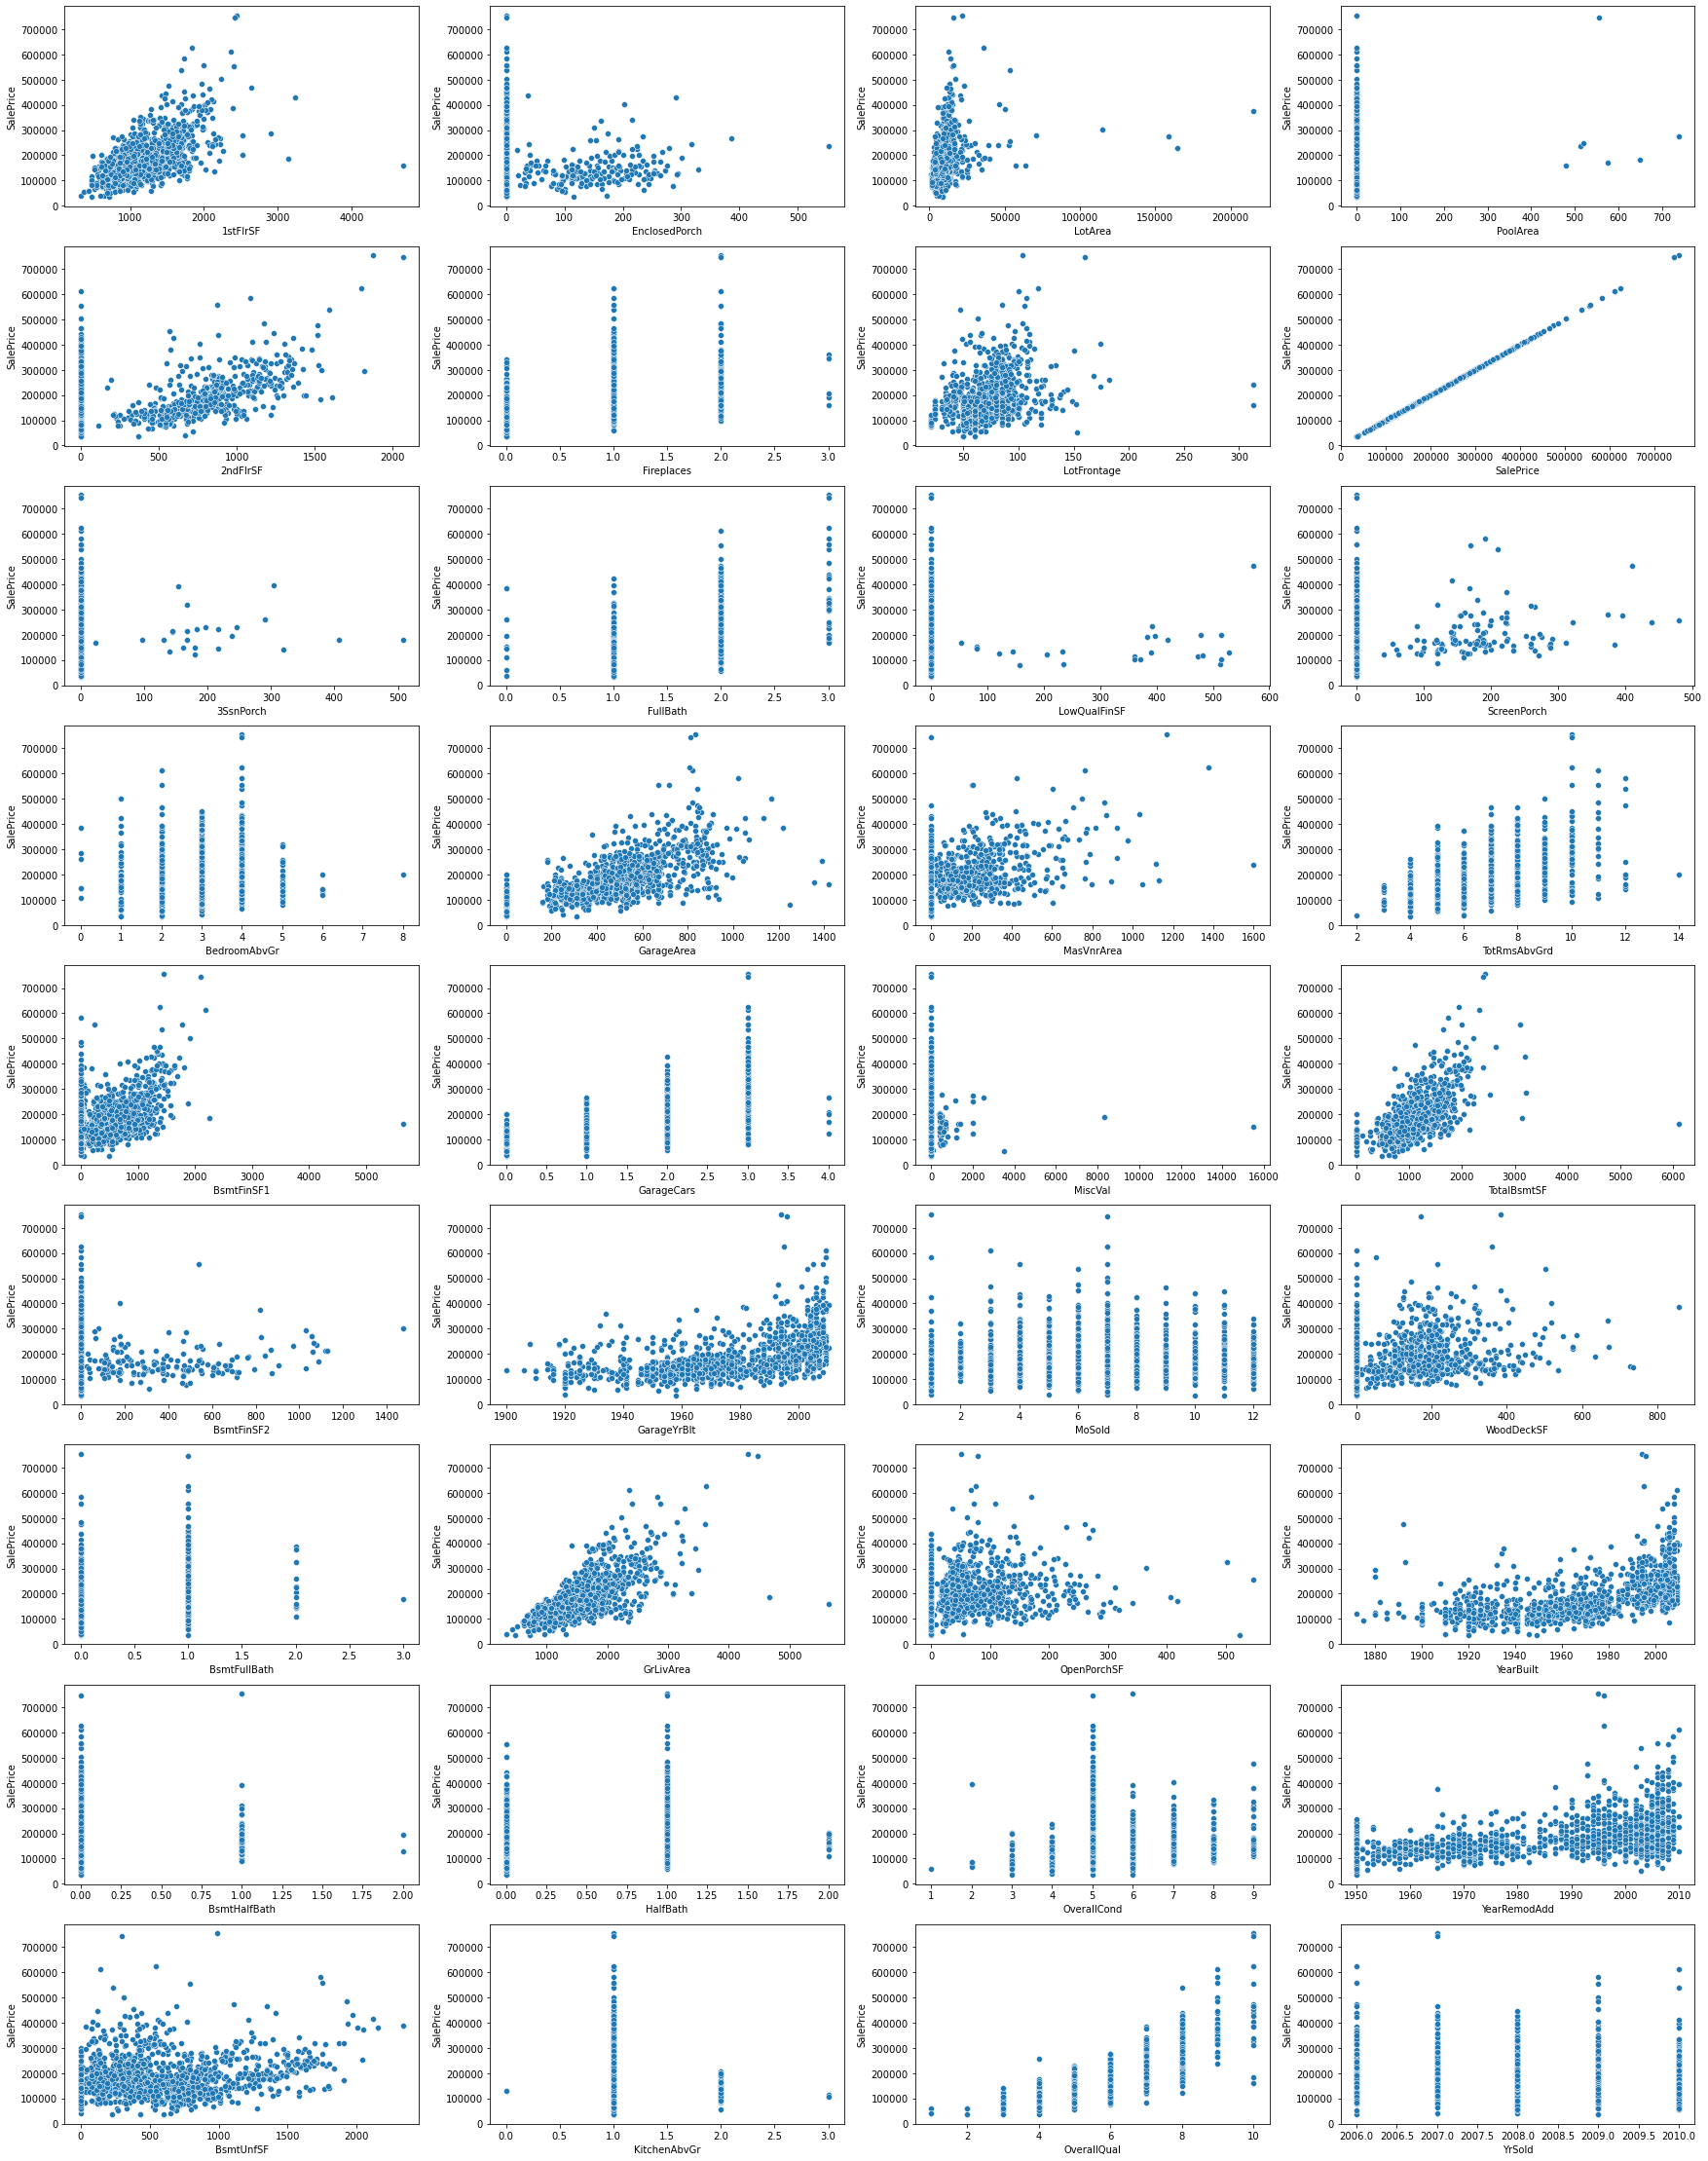

In [22]:
f, axes = plt.subplots(9, 4, figsize=(30, 40), sharex=False)
for i, feature in enumerate(numerical_features):
    sns.scatterplot(data=train_df, x = feature, y= "SalePrice",ax=axes[i%9, i//9])

* 'SalePrice' VS.'BsmtUnfSF',
* 'SalePrice' VS.'TotalBsmtSF',
* 'SalePrice' VS.'GarageArea',
* 'SalePrice' VS.'LotArea',
* 'SalePrice' VS.'LotFrontage',
* 'SalePrice' VS.'GrLivArea',
* 'SalePrice' VS.'1stFlrSF',


#### Correlations

In [23]:
corr_matrix = train_df[numerical_features].corr()

In [24]:
print(corr_matrix['SalePrice'].sort_values(ascending=False))

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


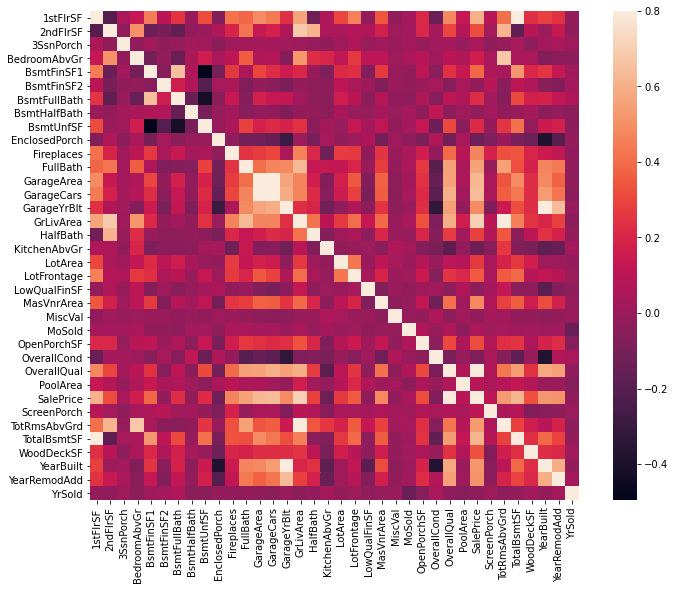

In [25]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=.8, square=True);

'SalePrice' correlation matrix


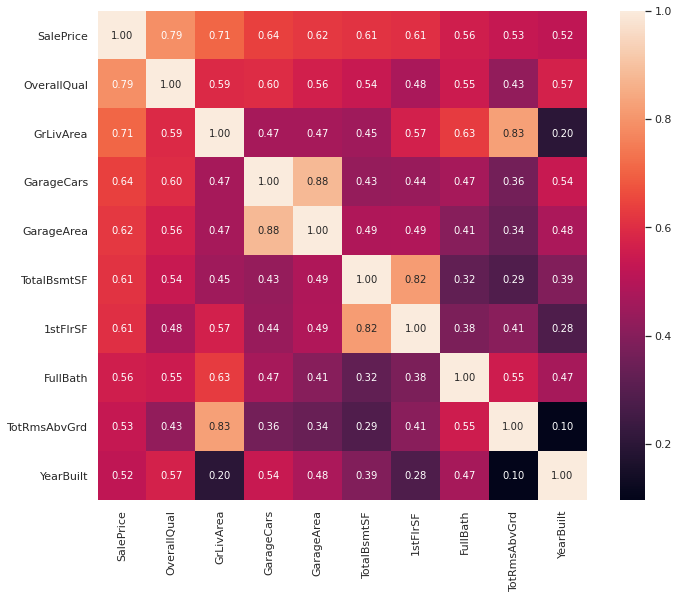

In [26]:
k = 10
cols = corr_matrix.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

* 'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'.
* 'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables. It makes sense that the area of garage determines how many cars can fit in. We just keep GarageCars.
* 'TotalBsmtSF' and '1stFloor' are also strongly correlated. It makes sense that the size of basement is not larger than the 1stFloor.
* 'TotRmsAbvGrd' and 'GrLivArea' have strong correlation as well.

### Simple model

Here I will try very simple model which use top 4 features which have large corellation coefficients with target variable

In [27]:
X = train_df[train_df.columns.drop('SalePrice')]
y = np.log(train_df['SalePrice'])

In [28]:
# check missing values
top_features = ['GrLivArea', 'OverallQual', 'GarageCars', 'TotalBsmtSF']
X[top_features].isnull().sum()

GrLivArea      0
OverallQual    0
GarageCars     0
TotalBsmtSF    0
dtype: int64

Luckily these features don't have missing values

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [30]:
def df_cols_selector(col_names):
    return FunctionTransformer(lambda x: x[col_names], validate=False)

In [31]:
from sklearn.model_selection import cross_val_score

def cross_validate_model(estimator, X, y, cv=3):
    cv_scores = cross_val_score(estimator, X, y, error_score='raise', scoring='neg_root_mean_squared_error', cv=cv)
    rmse_mean = np.abs(cv_scores).mean()
    rmse_std = np.abs(cv_scores).std()
    return rmse_mean, rmse_std

For linear models it is important that all numeric features are on the same scale, so we will use StandardScaler

In [32]:
pipeline_simple = Pipeline([
    ('selector', df_cols_selector(top_features)),
    ('scaler', StandardScaler()),
    ('lm', LinearRegression())
])
cross_validate_model(pipeline_simple, X, y)

(0.1856619374552374, 0.006332915589858256)

## Handling missing values

We can not just train model without dealing with missing values. There are several strategies how to deal with them. Each approach has it's pros and cons. One strategy is to remove all rows with have missing data. It is not suitable for us as test data may contain missing values. We can drop all columns which contain missing data, however we could lose important information. The third way is to fill missing data with some appropriate values. It could be median, mean, most frequent value etc.

In [33]:
numeric_null_vals = train_df[numerical_features].isnull().sum()
numeric_null_vals[numeric_null_vals > 0].sort_values(ascending=False)

LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
dtype: int64

**LotFrontage**: Linear feet of street connected to property. It seems we can fill missing values with 0.

**GarageYrBlt**: Year garage was built. It is reasonable to use the YearBuilt to fill the missing GarageYrBlt

**MasVnrArea**: Masonry veneer area in square feet. It seems we can fill missing values with 0.




### Temporal Variable 

In [34]:
def handle_year_features(df):
    df['GarageYrBlt'].fillna(df['YearBuilt'], inplace=True)
    
    for feature in ['YearBuilt','YearRemodAdd','GarageYrBlt']:
        df[feature] = df['YrSold'] - df[feature]
        
    return df
        
X = handle_year_features(X)

In [35]:
# Drop the unuseful numerical features mentioned before
numerical_features.remove('BsmtHalfBath')
numerical_features.remove('PoolArea')
numerical_features.remove('LowQualFinSF')
numerical_features.remove('3SsnPorch')
numerical_features.remove('MiscVal')


### Linear regression model with numeric features

In [36]:
print(numerical_features)

['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'MasVnrArea', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'SalePrice', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']


In [37]:
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

numerical_features.remove('SalePrice')
pipeline_num = Pipeline([
    ('selector', df_cols_selector(numerical_features)),
    ('imputer', KNNImputer(n_neighbors=20)),
    ('scaler', StandardScaler()),
    ('lm', LinearRegression())
])
cross_validate_model(pipeline_num, X, y)

(0.1599841562034915, 0.015000330143657044)

Using all numeric features allows our model to improve it's predictions

### Categorical features   
So far we haven't looked at categorical features. Let's now explore them

In [38]:
categorical_features.append('MSSubClass')
categorical_features.sort()
print(categorical_features)


['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'Utilities']


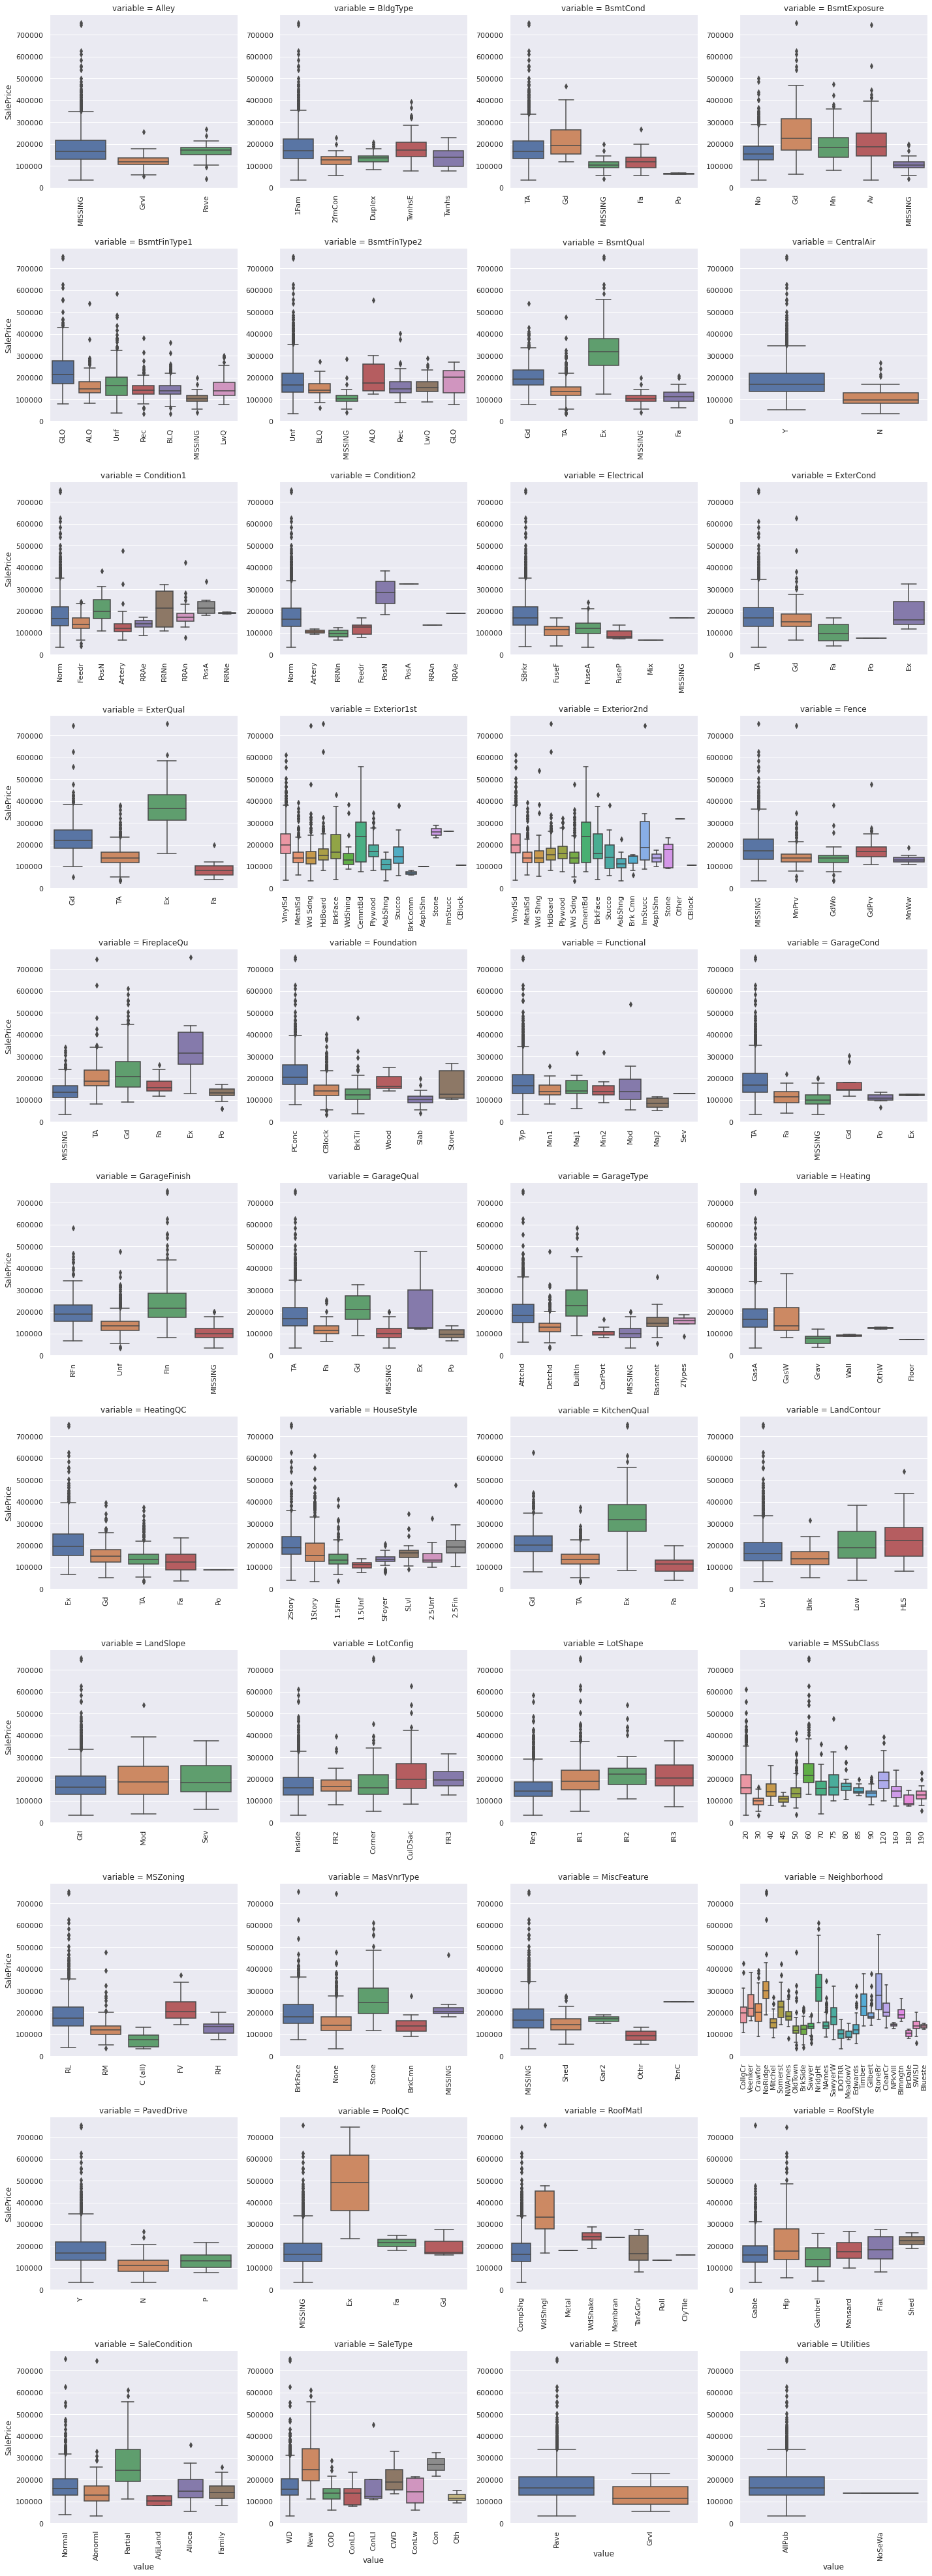

In [39]:
train_df_copy = train_df.copy()
for c in categorical_features:
    train_df_copy[c] = train_df_copy[c].astype('category')
    if train_df_copy[c].isnull().any():
        train_df_copy[c] = train_df_copy[c].cat.add_categories(['MISSING'])
        train_df_copy[c] = train_df_copy[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train_df_copy, id_vars=['SalePrice'], value_vars=categorical_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")

As I removed **PoolArea**, I will remove **PoolQC** as well.

In [40]:
categorical_features.remove('PoolQC')

In [41]:
# Number of unique values among columns with numeric data
train_df[categorical_features].nunique().sort_values()

Alley             2
Street            2
CentralAir        2
Utilities         2
LandSlope         3
GarageFinish      3
PavedDrive        3
Fence             4
BsmtExposure      4
LotShape          4
KitchenQual       4
MasVnrType        4
MiscFeature       4
LandContour       4
BsmtCond          4
BsmtQual          4
ExterQual         4
ExterCond         5
Electrical        5
FireplaceQu       5
MSZoning          5
GarageCond        5
BldgType          5
LotConfig         5
HeatingQC         5
GarageQual        5
RoofStyle         6
SaleCondition     6
BsmtFinType1      6
GarageType        6
Foundation        6
BsmtFinType2      6
Heating           6
Functional        7
Condition2        8
RoofMatl          8
HouseStyle        8
Condition1        9
SaleType          9
MSSubClass       15
Exterior1st      15
Exterior2nd      16
Neighborhood     25
dtype: int64

### Dealing with missing data

Just like numeric features, it is possible to have missing values for categorical features. Let's take a look how many missing values we have

In [42]:
missing_vals_cat = train_df[categorical_features].isnull().sum()

In [43]:
missing_vals_cat

Alley            1369
BldgType            0
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinType2       38
BsmtQual           37
CentralAir          0
Condition1          0
Condition2          0
Electrical          1
ExterCond           0
ExterQual           0
Exterior1st         0
Exterior2nd         0
Fence            1179
FireplaceQu       690
Foundation          0
Functional          0
GarageCond         81
GarageFinish       81
GarageQual         81
GarageType         81
Heating             0
HeatingQC           0
HouseStyle          0
KitchenQual         0
LandContour         0
LandSlope           0
LotConfig           0
LotShape            0
MSSubClass          0
MSZoning            0
MasVnrType          8
MiscFeature      1406
Neighborhood        0
PavedDrive          0
RoofMatl            0
RoofStyle           0
SaleCondition       0
SaleType            0
Street              0
Utilities           0
dtype: int64

In [44]:
missing_vals_cat[missing_vals_cat > 0].sort_values(ascending=False)

MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
GarageCond        81
GarageFinish      81
GarageQual        81
GarageType        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtFinType1      37
BsmtQual          37
MasVnrType         8
Electrical         1
dtype: int64

**MiscFeature**: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None

I will remove column **MiscFeature** entirely.
For **Alley** we could replace NAs with "No Alley"

**Fence**: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence
**Solution**: Replace NAs with "No Fence"

FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
**Solution**: replace NAs with "No Fireplace"       

For all columns which contains "Garage" in it's name replace N/As with "No Garage"  
For all columns which contains "Bsmt" in it's name replace N/As with "No Basement"  
**MasVnrType** - for now I will replace NA/s "None" because for **MasVnrArea** I replaced N/As with 0. Perhabs it is reasonable to treat N/As for this features differently  
For **Electrical** - most common value


In [45]:
train_df['Electrical'].mode()

0    SBrkr
dtype: object

In [46]:
# Here I redefine fill_missing_vals to handle all columns with missing values
def fill_missing_vals(df: pd.DataFrame) -> None:
    values_to_fill = {
        #"LotFrontage": impute with KNNImputer
        "MasVnrArea": 0,
        "Fence": "No Fence",
        "FireplaceQu": "No Fireplace",
        "Alley": "No Alley",
        "GarageType": "No Garage",
        "GarageFinish": "No Garage",
        "GarageQual": "No Garage",
        "GarageCond": "No Garage",
        "BsmtExposure": "No Basement",
        "BsmtFinType2": "No Basement",
        "BsmtQual": "No Basement",
        "BsmtCond": "No Basement",
        "BsmtFinType1": "No Basement",
        "MasVnrType": "Not Given",
        "Electrical": "SBrkr"
    }
    df = df.fillna(values_to_fill)
    return df

In [47]:
X = fill_missing_vals(X)

### Feature Engineering  
Here I will create some additional features in hope that they helps a model to do better job. The idea for **Total_Bathrooms** and **TwoFlrsSF** is borrowed for notebooks of other participants

In [48]:
def add_features(df: pd.DataFrame):
    df.loc[:, 'PorchArea'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']

    df.loc[:, 'Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                               df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

    df.loc[:, "TwoFlrsSF"] = df["1stFlrSF"] + df["2ndFlrSF"]
    return df

In [49]:
X = add_features(X)
train_df = add_features(train_df)

In [50]:
numerical_features.append('Total_Bathrooms')
numerical_features.append('TwoFlrsSF')
numerical_features.append('PorchArea')

categorical_features.remove('MiscFeature')

### Feature Selection  

As we can suppose from the plots above, some of the features have a dominant value. Perhabs our model won't be able to extract useful information from those features. Here I exclude all columns for which most common value appears for more than 96% of the rows

In [51]:
for f_name in categorical_features:
    val_counts = train_df[f_name].value_counts()
    not_null_vals = train_df[f_name].notnull().sum()
    val_props = val_counts / not_null_vals
    max_proportion = val_props.max()
    most_common = val_counts.index[0]
    if max_proportion > 0.96:
        print(f'{f_name}: "{most_common}" - {max_proportion}')
        categorical_features.remove(f_name)       

Condition2: "Norm" - 0.9897260273972602
GarageCond: "TA" - 0.9615663524292966
Heating: "GasA" - 0.9780821917808219
RoofMatl: "CompShg" - 0.9821917808219178
Street: "Pave" - 0.9958904109589041


In [52]:
for f_name in numerical_features:
    val_counts = train_df[f_name].value_counts()
    not_null_vals = train_df[f_name].notnull().sum()
    val_props = val_counts / not_null_vals
    max_proportion = val_props.max()
    most_common = val_counts.index[0]
    if max_proportion > 0.96:
        print(f'{f_name}: "{most_common}" - {max_proportion}')
        numerical_features.remove(f_name) 


### Base model

Here I am going to set up a base model which results than will be used to compare with other models

In [53]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion


def get_pipeline(estimator, num_features, cat_features):
    num_pipeline = Pipeline([
        ('selector', df_cols_selector(num_features)),
        ('imputer', KNNImputer(n_neighbors=20)),
        ('scaler', StandardScaler())
    ])
    cat_pipeline = Pipeline([
        ('selector', df_cols_selector(cat_features)),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('oh', OneHotEncoder(handle_unknown='ignore'))
    ])

    feature_union = FeatureUnion(transformer_list=[
        ('numeric_features', num_pipeline),
        ('cat_features', cat_pipeline)
    ])

    pipeline = Pipeline([
        ('feature_union', feature_union),
        ('estimator', estimator)
    ])
    return pipeline

In [54]:
bm_pipeline = get_pipeline(LinearRegression(), numerical_features, categorical_features)

In [55]:
cross_validate_model(bm_pipeline, X, y)

(0.15119629083650574, 0.0076943921411286665)

### Ridge regression

In [56]:
from sklearn.linear_model import Ridge
ridge_pipeline = get_pipeline(Ridge(alpha=8), numerical_features, categorical_features)
cross_validate_model(ridge_pipeline, X, y)

(0.14110595706241977, 0.010683453666963093)

### Random Forest Regressor

In [57]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=500, max_depth=18, max_features='sqrt', n_jobs=-1, random_state=816)
rf_pipeline = get_pipeline(rf_reg, numerical_features, categorical_features)
cross_validate_model(rf_pipeline, X, y)

(0.14312431264109635, 0.010919734673288311)

### XGB boost

In [58]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(n_estimators=1000, max_depth=4, colsample_bytree=0.2, n_jobs=2)
xgb_pipeline = get_pipeline(xgb_reg, numerical_features, categorical_features)
cross_validate_model(xgb_pipeline, X, y)

(0.13536654229324493, 0.008048257295256945)

So far XGB regressor appears to be the best model. It is reasonable to explore how each other model will perform with properly chosen hyperparameters. But at least for now I will focus only on XGB regressor.

## Hyperparameter tuning

Hyperparameters have a significant impact on model's performance. There are multiple techniques how to select them. [optuna](https://optuna.org/) is used here.



In [59]:
print(numerical_features)

['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'MasVnrArea', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold', 'Total_Bathrooms', 'TwoFlrsSF', 'PorchArea']


In [60]:
print(categorical_features)

['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageFinish', 'GarageQual', 'GarageType', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'Neighborhood', 'PavedDrive', 'RoofStyle', 'SaleCondition', 'SaleType', 'Utilities']


In [61]:
import optuna
from optuna import Trial

def xgb_reg_objective(trial: Trial):

    n_estimators = trial.suggest_int('n_estimators', 950, 2000, 50)
    max_depth = trial.suggest_int('max_depth', 3, 8, step=1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 0.9, step=0.05)
    learning_reate = trial.suggest_loguniform('learing_rate', 1e-2, 0.4)

    xgb_reg = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, colsample_bytree=colsample_bytree, learning_rate=learning_reate, n_jobs=2, random_state=816)
    pipeline = get_pipeline(xgb_reg, numerical_features, categorical_features)
    score = cross_validate_model(pipeline, X, y)
    return score[0] 

study = optuna.create_study(direction='minimize')
study.optimize(xgb_reg_objective, n_trials=300)

[I 2021-08-08 23:35:42,471] A new study created in memory with name: no-name-f5361ac5-7be3-4355-88f1-f711820b3fc4
[I 2021-08-08 23:35:48,273] Trial 0 finished with value: 0.12108404883517387 and parameters: {'n_estimators': 1500, 'max_depth': 5, 'colsample_bytree': 0.2, 'learing_rate': 0.03256233804095784}. Best is trial 0 with value: 0.12108404883517387.
[I 2021-08-08 23:36:03,800] Trial 1 finished with value: 0.12913649221153856 and parameters: {'n_estimators': 1400, 'max_depth': 8, 'colsample_bytree': 0.85, 'learing_rate': 0.02438601737623809}. Best is trial 0 with value: 0.12108404883517387.
[I 2021-08-08 23:36:07,369] Trial 2 finished with value: 0.1254628107163279 and parameters: {'n_estimators': 1000, 'max_depth': 3, 'colsample_bytree': 0.30000000000000004, 'learing_rate': 0.14950228105397761}. Best is trial 0 with value: 0.12108404883517387.
[I 2021-08-08 23:36:11,789] Trial 3 finished with value: 0.13039020746193344 and parameters: {'n_estimators': 1250, 'max_depth': 4, 'colsa

In [62]:
best_params = study.best_params
print(best_params)

{'n_estimators': 1700, 'max_depth': 3, 'colsample_bytree': 0.15000000000000002, 'learing_rate': 0.02326412858047198}


In [63]:
xgb_reg_tuned = XGBRegressor(n_estimators=int(best_params['n_estimators']),
                             max_depth=int(best_params['max_depth']),
                             colsample_bytree=float(best_params['colsample_bytree']),
                             learning_rate=float(best_params['learing_rate']), n_jobs=2, random_state=816)
xgb_pipeline_tuned = get_pipeline(xgb_reg_tuned, numerical_features, categorical_features)

In [64]:
cross_validate_model(xgb_pipeline_tuned, X, y)

(0.11752126915550366, 0.012845581882196947)

## Submission

In [65]:
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [66]:
train_df = fill_missing_vals(train_df)
train_df = add_features(train_df)
train_df = handle_year_features(train_df)

test_df = fill_missing_vals(test_df)
test_df = add_features(test_df)
test_df = handle_year_features(test_df)


In [67]:
xgb_pipeline_tuned.fit(train_df[train_df.columns.drop('SalePrice')], np.log(train_df['SalePrice']))
y_pred_test = xgb_pipeline_tuned.predict(test_df)
y_pred_test = np.exp(y_pred_test)

In [68]:
import csv


def prepare_submission(test_data: pd.DataFrame, predicted: np.ndarray):git
    with open(f"submissions.csv", mode="w") as f:
        csv_writer = csv.DictWriter(f, fieldnames=['Id', "SalePrice"])
        csv_writer.writeheader()
        for idx, df_row in test_data.iterrows():
            csv_writer.writerow({"Id": df_row['Id'], "SalePrice": predicted[idx]})

In [69]:
prepare_submission(test_df, y_pred_test)

In [70]:
y_pred_test[:15]

array([126120.4  , 160090.08 , 182339.14 , 197742.53 , 186194.33 ,
       171539.92 , 175844.   , 163849.78 , 183359.06 , 126558.25 ,
       193446.86 ,  96719.69 ,  99133.7  , 150547.11 , 114639.484],
      dtype=float32)